# The Appendix

# Preparing the Data Set

In [12]:
!pip install datasets
%pip install scikit-lego

In [13]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklego.linear_model import LADRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Our chosen dataset contains Spotify tracks over a range of 125 different genres which lists audio features of each track. There are 114000 rows and 21 columns.

In [14]:
from datasets import load_dataset

# load in CSV data file
ds = load_dataset("maharshipandya/spotify-tracks-dataset", split="train")

# Convert the 'train' dataset to a pandas DataFrame
spotify_df = pd.DataFrame(ds)

In [15]:
# Remove the rows with missing values, since there is only one row our of 114K rows, we decided it is insignificant
spotify_clean = spotify_df.dropna()

# Drop duplicates while keeping the first occurrence
spotify_cleaned = spotify_clean.drop_duplicates(subset='track_id', keep='first')

# all NUMERIC the features
numeric_features = [
    'duration_ms',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo'
]

X = spotify_cleaned[numeric_features]
y = spotify_cleaned['popularity']  # Response variable

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 1) Data Cleaning and EDA

## Examine the data set

### Exploring Data Features

In [16]:
# Check what variables are available in the dataset
print(ds.column_names)

# Display the first few rows of the DataFrame
print(spotify_df.head())

# Print out the column names with the corresponding data types, also checked that the column names are understandable
print(spotify_df.dtypes)

# Get a list of unique genres
spotify_df['track_genre'].unique()

# Check how many observations are in the data set
print("Number of rows:", spotify_df.shape[0])

['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']
   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On 

- **Structure and Features**: The dataset contains 21 columns, each representing specific attributes of Spotify tracks, including metadata like track_id, artists, album_name, and track_name, as well as audio features such as danceability, energy, and loudness. The popularity column, a key feature, measures track popularity on a scale of 0 to 100.

- **Data Types**: Columns are appropriately typed, such as integers (popularity, key), floats (danceability, tempo), and objects for categorical data (artists, track_genre).

- **Sample Data**: The first few rows show examples of tracks with metadata and audio features. For example, the track "Comedy" by Gen Hoshino has a popularity score of 73 and a danceability of 0.676.

- **Genres**: The dataset encompasses a wide variety of genres, totaling over 125 unique categories, such as 'acoustic', 'j-pop', 'rock', and 'hip-hop'.

### Missingness

In [17]:
# look for which rows have missing values
missing_values_rows = spotify_df[spotify_df.isnull().any(axis=1)]
print(missing_values_rows)

       Unnamed: 0                track_id artists album_name track_name  \
65900       65900  1kR4gIb7nGxHPI3D2ifs59    None       None       None   

       popularity  duration_ms  explicit  danceability  energy  ...  loudness  \
65900           0            0     False         0.501   0.583  ...     -9.46   

       mode  speechiness  acousticness  instrumentalness  liveness  valence  \
65900     0       0.0605          0.69           0.00396    0.0747    0.734   

         tempo  time_signature  track_genre  
65900  138.391               4        k-pop  

[1 rows x 21 columns]


The dataset contains one row with missing values at index 65900. The missing data pertains to artists, album_name, and track_name. Since there is only one row missing, we decided it would be best to remove the row as it would be negligible in the context of 114,000 rows.

In [18]:
# Remove the rows with missing values
# since there is only one row out of 114K rows, we decided it is insignificant
spotify_cleaned = spotify_df.dropna()

# Check that missing values have been dropped
missing_values = spotify_cleaned.isnull().sum()
print(missing_values)

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


### Duplicates

In [19]:
# Look for duplicates in track ID
duplicate_track_ids = spotify_df[spotify_df.duplicated(subset='track_id', keep=False)]
# print("Number of duplicate track IDs: ", duplicate_track_ids.shape[0])
# print(duplicate_track_ids)

# Find the unique groups of track_id duplicates
unique_duplicate_groups = duplicate_track_ids['track_id'].nunique()

print("Number of unique groups of duplicate track_id:", unique_duplicate_groups)

Number of unique groups of duplicate track_id: 16641


In [20]:
# Select numerical features only
# numerical_features = spotify_df.select_dtypes(include=['float64', 'int64']).columns

# Filter for duplicates
duplicate_track_ids = spotify_df[spotify_df.duplicated(subset='track_id', keep=False)]

# Check if duplicates are identical for numerical features
identical_numerical_duplicates = duplicate_track_ids.groupby('track_id').apply(
    lambda group: group[numeric_features].nunique().max() == 1
)

# Print to quickly see the counts of identical and non-identical groups
print("Number of identical and non-identical groups", identical_numerical_duplicates.value_counts())

Number of identical and non-identical groups True    16641
Name: count, dtype: int64


<ipython-input-20-c8461fb60156>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  identical_numerical_duplicates = duplicate_track_ids.groupby('track_id').apply(


In [21]:
identical_duplicates = spotify_cleaned[spotify_cleaned.duplicated(subset='track_id', keep=False) &
                                       spotify_cleaned.duplicated(keep=False)]
print("number of identical duplicate track IDs: ", identical_duplicates.shape[0])

number of identical duplicate track IDs:  0


Since all the columns are identical in the numeric features of the duplicates, the only difference was in the track_genre, which we did not use within our code, we decided to drop duplicates, keeping the first one in the index.

In [22]:
resolved_duplicates = spotify_clean.drop_duplicates(subset='track_id', keep='first')
print("number of resolved duplicate track IDs: ", resolved_duplicates.shape[0])

number of resolved duplicate track IDs:  89740


In [23]:
has_duplicates = resolved_duplicates.duplicated(subset='track_id', keep=False).any()
print("Does the DataFrame still have duplicates?", has_duplicates)

Does the DataFrame still have duplicates? False


In [24]:
missing_resolved = resolved_duplicates[resolved_duplicates.isnull().any(axis=1)]
print(missing_resolved)

Empty DataFrame
Columns: [Unnamed: 0, track_id, artists, album_name, track_name, popularity, duration_ms, explicit, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature, track_genre]
Index: []

[0 rows x 21 columns]


In [25]:
# Reassign cleaned without duplicates to spotify_cleaned
spotify_cleaned = resolved_duplicates

## Exploratory Data Analysis

For this project, we try to study what audio features in a song lead to increased popularity. To help determine predictors for popularity (the response variable), we can first use simple linear regression:

We decided to start by visualizing the relationship between each feature and popularity.

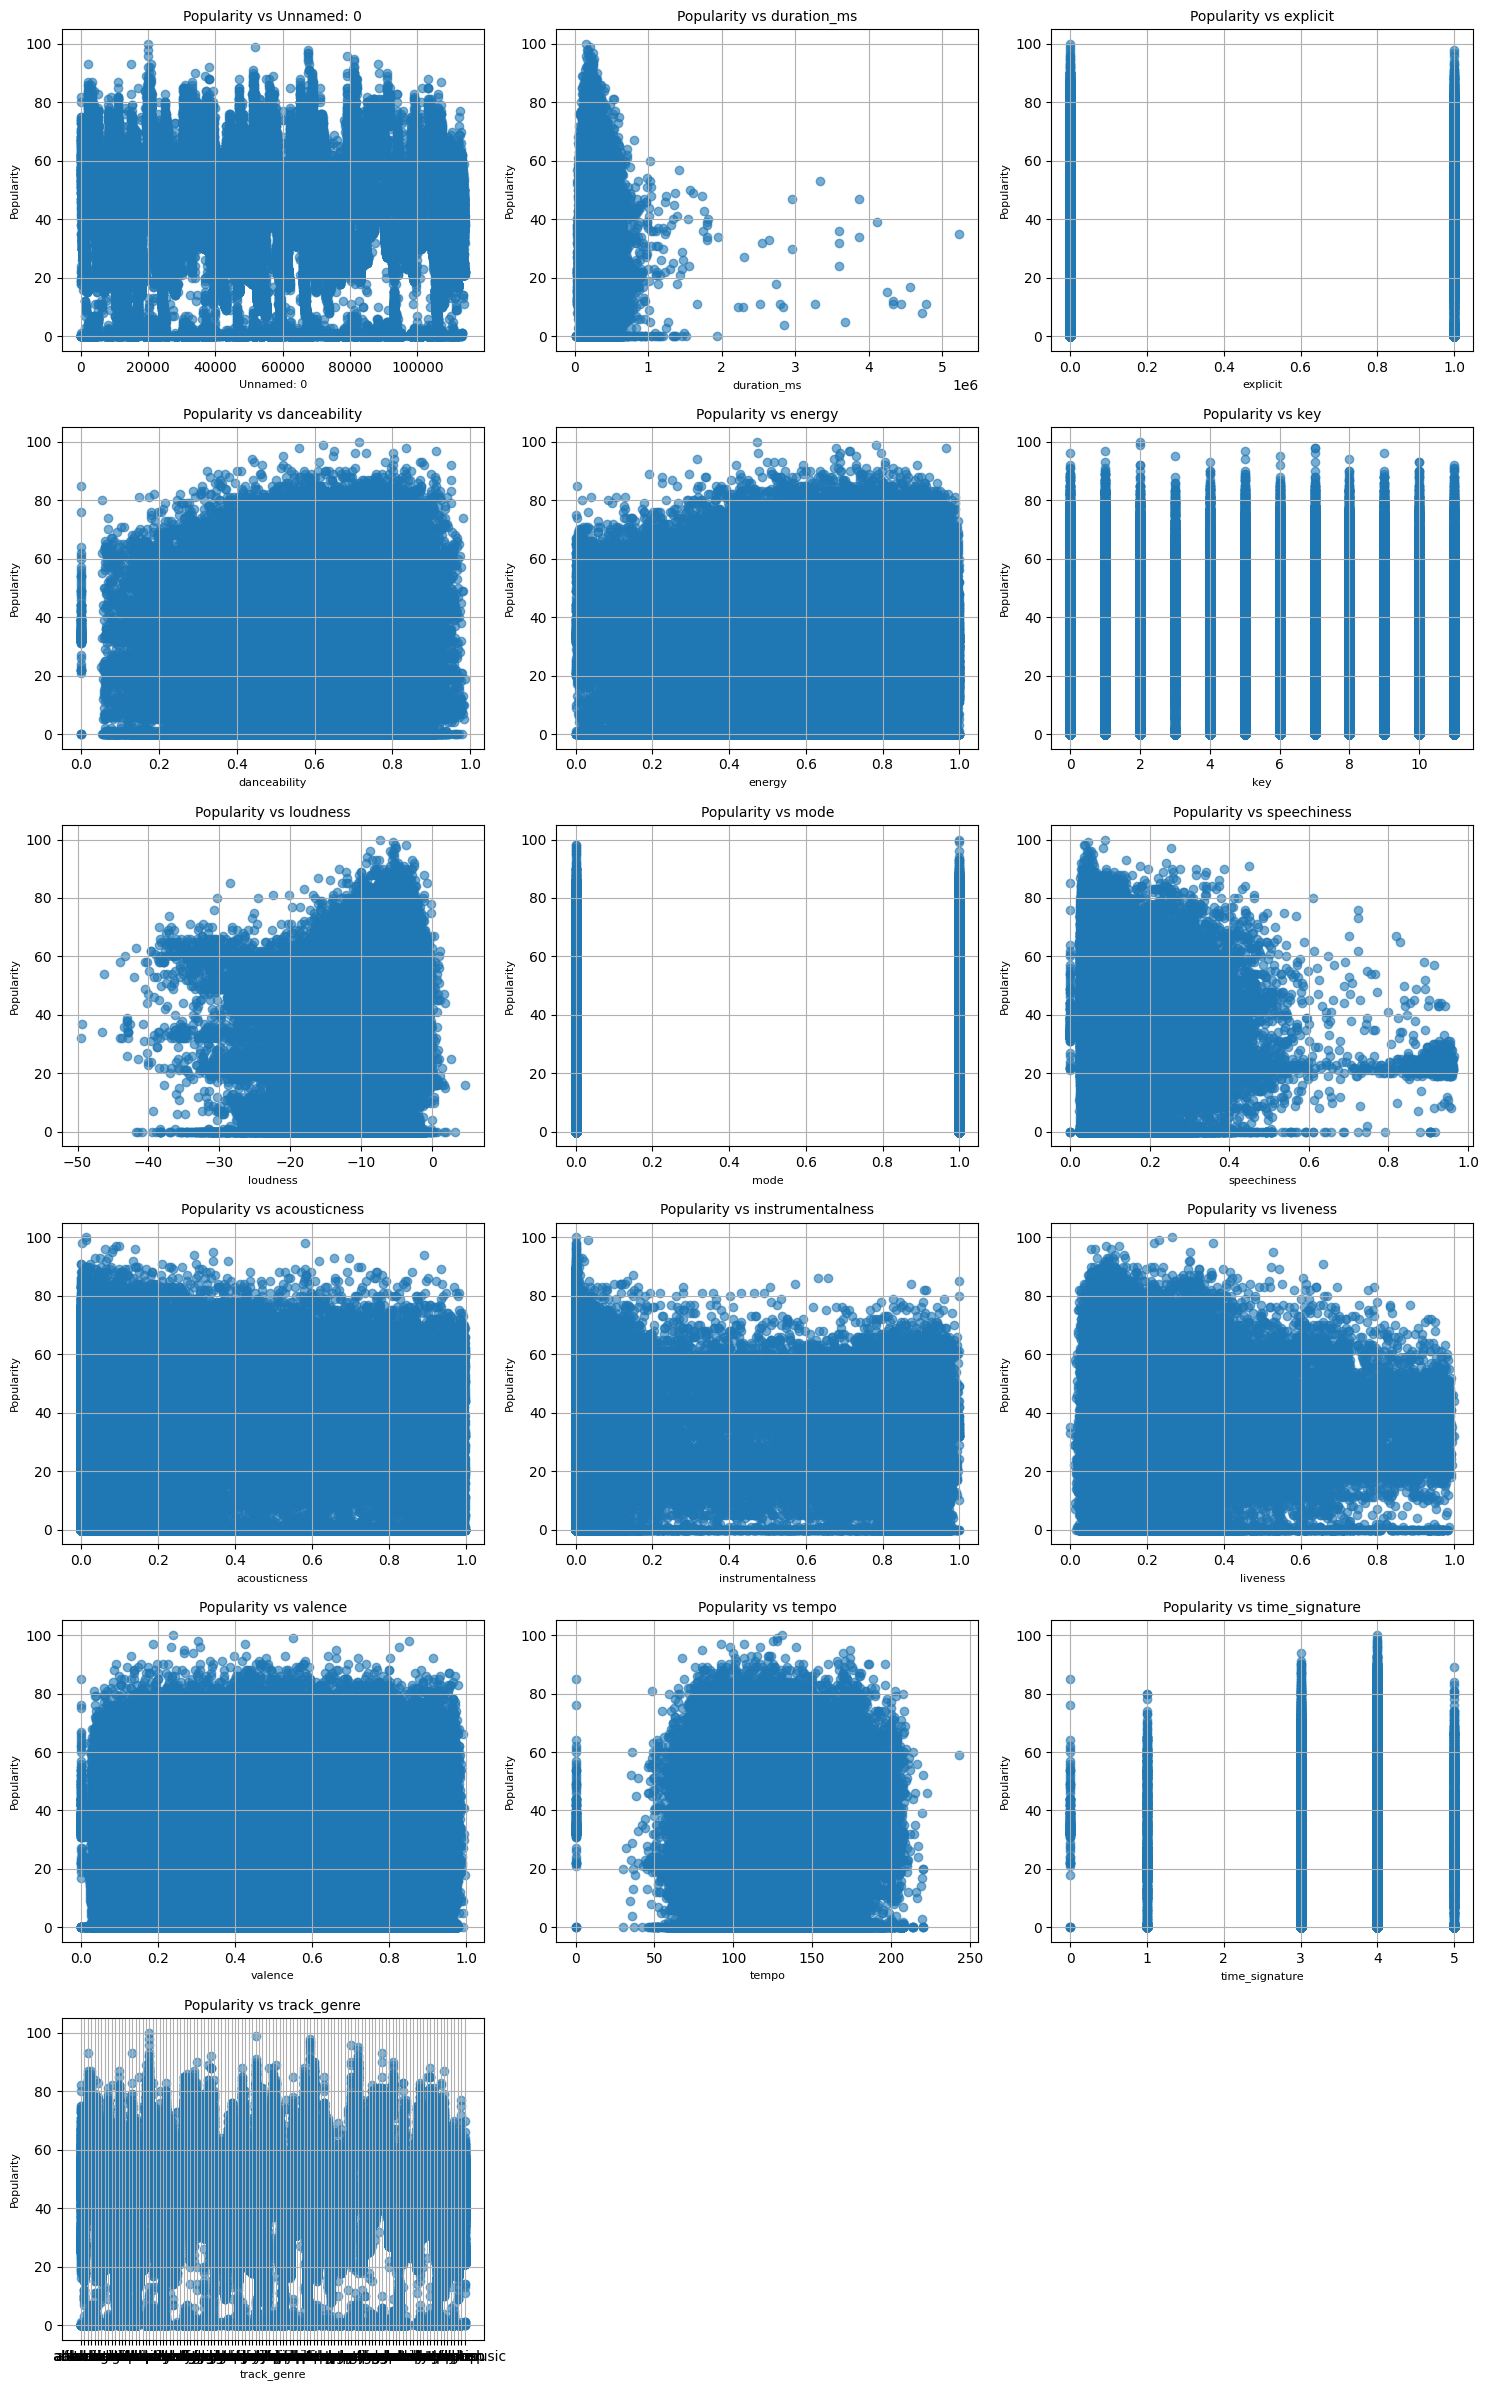

In [26]:
import matplotlib.pyplot as plt

# Exclude columns that are not relevant
excluded_columns = ['track_id', 'artists', 'album_name', 'track_name']
features_to_plot = [col for col in resolved_duplicates.columns if col not in excluded_columns and col != 'popularity']

# Number of features to plot
num_features = len(features_to_plot)

# Determine the grid size (e.g., 3 columns per row)
columns = 3
rows = -(-num_features // columns)  # Ceiling division to determine rows

# Create subplots
fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 4))  # Adjust figsize for size of the plots
axes = axes.flatten()  # Flatten to iterate easily

# Plot each feature
for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    ax.scatter(resolved_duplicates[feature], resolved_duplicates['popularity'], alpha=0.6)
    ax.set_title(f'Popularity vs {feature}', fontsize=10)
    ax.set_xlabel(feature, fontsize=8)
    ax.set_ylabel('Popularity', fontsize=8)
    ax.grid(True)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for readability
plt.tight_layout()
plt.show()


The scatter plots showcase the relationship between song popularity and various Spotify features, such as duration, danceability, energy, loudness, and acoustics. Key observations include a concentration of popular tracks within specific ranges for attributes like loudness and danceability, suggesting these features might influence popularity. Variables like mode and explicitness show minimal variation, indicating weaker correlations. The genre plot highlights a diverse distribution of popularity across different genres, while features like tempo and valence appear more evenly spread. These insights can guide further exploration into which features most significantly impact song popularity, which we consider in depth next.

# 2) Variable Selection, Linear Regression, Regularization

Our response variable is "popularity"


We use "popularity" as the response variable because it is numeric (ranging from 1 to 100) and serves as a reliable measure of a song's success, reflecting listener engagement and overall performance.


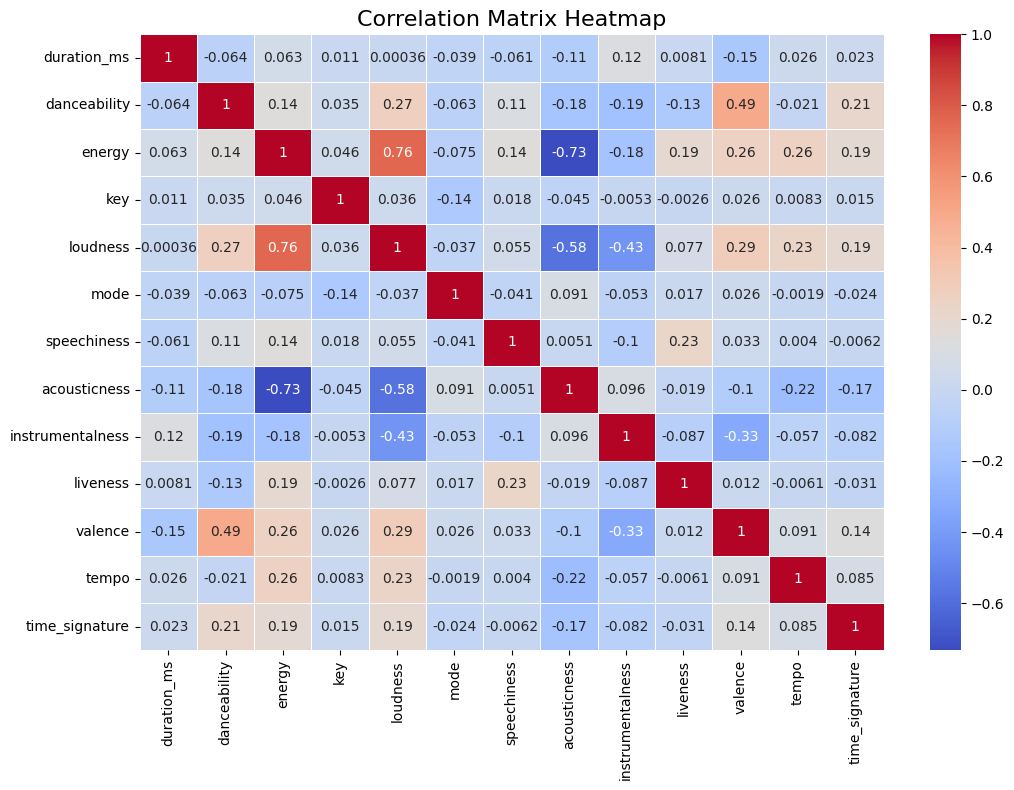

Highly correlated pairs: 
 energy    loudness    0.758774
loudness  energy      0.758774
dtype: float64


In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the numeric features for analysis
numeric_features = [
    'duration_ms', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]

# Extract numeric features from the dataset
X = spotify_cleaned[numeric_features]

# 1. Correlation Matrix (Heatmap)
# Compute the correlation matrix for numeric features
correlation_matrix = X.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

# Identify highly correlated feature pairs (correlation > 0.7 but < 1.0)
high_corr_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", ascending=False)
high_corr_pairs = high_corr_pairs[(high_corr_pairs > 0.7) & (high_corr_pairs < 1)]
print("Highly correlated pairs: \n", high_corr_pairs)

In [62]:
# Variance Inflation Factor (VIF)
# VIF helps detect multicollinearity among predictors in regression models

# Add a constant column for VIF calculation (required by statsmodels)
X_with_const = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [
    variance_inflation_factor(X_with_const.values, i)
    for i in range(1, X_with_const.shape[1])
]

# Print the VIF values
print("\nVariance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
             Feature       VIF
0        duration_ms  1.052088
1       danceability  1.565995
2             energy  4.261475
3                key  1.022826
4           loudness  3.269277
5               mode  1.041652
6        speechiness  1.146349
7       acousticness  2.417368
8   instrumentalness  1.470511
9           liveness  1.158529
10           valence  1.600737
11             tempo  1.096353
12    time_signature  1.082555


A VIF value indicates how much the variance of a regression coefficient is inflated due to multicollinearity. Most features have VIF values below 5, indicating low multicollinearity. These features are not highly correlated with other predictors, making them suitable for inclusion in the regression model. Only energy and loudness have high VIF values but since their correlation is less than 0.8, we decided not to drop any column.

In [63]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import pandas as pd

# Define numeric features for the model
numeric_features = [
    'duration_ms', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'time_signature'
]

# Select features (X) and target variable (y)
X = spotify_clean[numeric_features]  # Predictor variables
y = spotify_clean['popularity']      # Response variable

print("Features and Target Selected")
print(f"Features: {numeric_features}")
print(f"Target: popularity")

# Initialize the regression model
model = LinearRegression()
print("\nInitialized Linear Regression Model")

# Initialize the Sequential Feature Selector (Forward Selection)
# - n_features_to_select=4: Select the 4 most relevant features.
# - direction='forward': Starts with no features and adds them iteratively.
# - scoring='neg_mean_squared_error': Use negative MSE as the performance metric.
# - cv=5: Use 5-fold cross-validation for model evaluation.
selector = SequentialFeatureSelector(
    model,
    n_features_to_select=4,
    direction='forward',
    scoring='neg_mean_squared_error',
    cv=5
)

# Fit the feature selector to the data
print("\nFitting Sequential Feature Selector...")
selector.fit(X, y)
print("Feature selection completed.")

# Get the names of the selected features
selected_features = X.columns[selector.get_support()]
print("\nSelected Features")
print(f"Selected Features: {selected_features.tolist()}")

# Alternative way to print selected features
print(selector.get_feature_names_out())

Features and Target Selected
Features: ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
Target: popularity

Initialized Linear Regression Model

Fitting Sequential Feature Selector...
Feature selection completed.

Selected Features
Selected Features: ['danceability', 'speechiness', 'instrumentalness', 'valence']
['danceability' 'speechiness' 'instrumentalness' 'valence']


In [66]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# Step 1: Clean the dataset
# Retain only numeric columns for the model
spotify_df_clean = spotify_clean.select_dtypes(include=[np.number])

#  Define features (X) and target variable (y)
X = spotify_df_clean[selected_features.tolist()]
y = spotify_df_clean['popularity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Function to evaluate model performance
def evaluate_performance(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name):

    #Evaluate and print the model's performance on training and testing datasets.

    # Training performance
    y_pred_train = model.predict(X_train_scaled)
    train_r2 = r2_score(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)

    # Testing performance
    y_test_pred = model.predict(X_test_scaled)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Print results
    print(f"\n{model_name} Results:")
    print(f"Training R2 Score: {train_r2:.4f}")
    print(f"Training MSE: {train_mse:.4f}")
    print(f"Testing R2 Score: {test_r2:.4f}")
    print(f"Testing MSE: {test_mse:.4f}")

# Train and evaluate models

# Linear Regression
print("\nTraining Linear Regression model...")
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
evaluate_performance(lin_reg, X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")

#  Lasso Regression
print("\nTraining Lasso Regression model...")
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
evaluate_performance(lasso, X_train_scaled, X_test_scaled, y_train, y_test, "Lasso Regression")

# Ridge Regression
print("\nTraining Ridge Regression model...")
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_scaled, y_train)
evaluate_performance(ridge, X_train_scaled, X_test_scaled, y_train, y_test, "Ridge Regression")


Training Linear Regression model...

Linear Regression Results:
Training R2 Score: 0.0222
Training MSE: 486.7736
Testing R2 Score: 0.0190
Testing MSE: 486.6464

Training Lasso Regression model...

Lasso Regression Results:
Training R2 Score: 0.0221
Training MSE: 486.8454
Testing R2 Score: 0.0191
Testing MSE: 486.6266

Training Ridge Regression model...

Ridge Regression Results:
Training R2 Score: 0.0222
Training MSE: 486.7736
Testing R2 Score: 0.0190
Testing MSE: 486.6464


The results indicate that the models are underperforming significantly. All three models—Linear Regression, Lasso Regression, and Ridge Regression—yield nearly identical performance, with training and testing R^2scores close to 0 (0.022 and 0.019, respectively). This suggests that the models explain only about 2% of the variance in the target variable (popularity), highlighting poor predictive capability. Additionally, the high Mean Squared Error (MSE) values (~487 for training and ~483 for testing) indicate substantial errors in predictions. The similarity in performance across the models implies that regularization in Lasso and Ridge did not enhance model effectiveness, likely because the selected features have limited predictive power for the target variable.

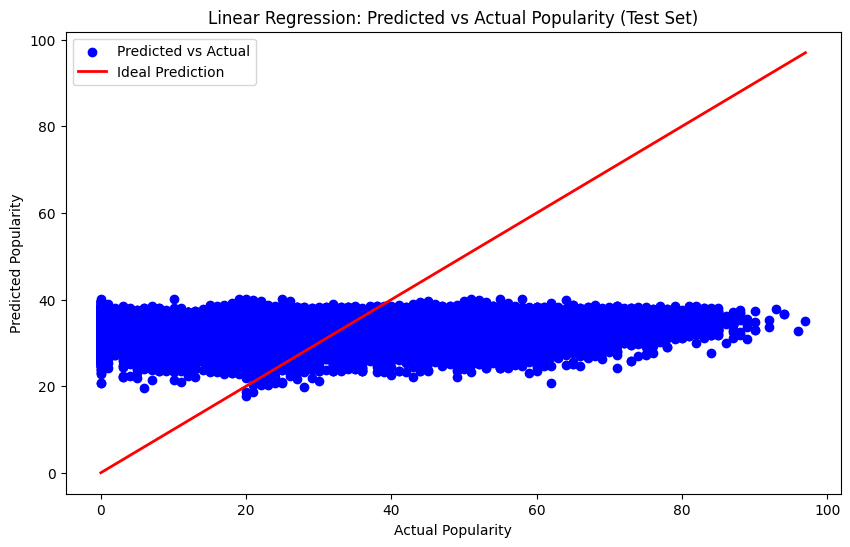

Displayed Actual vs Predicted Popularity plot for the test set.


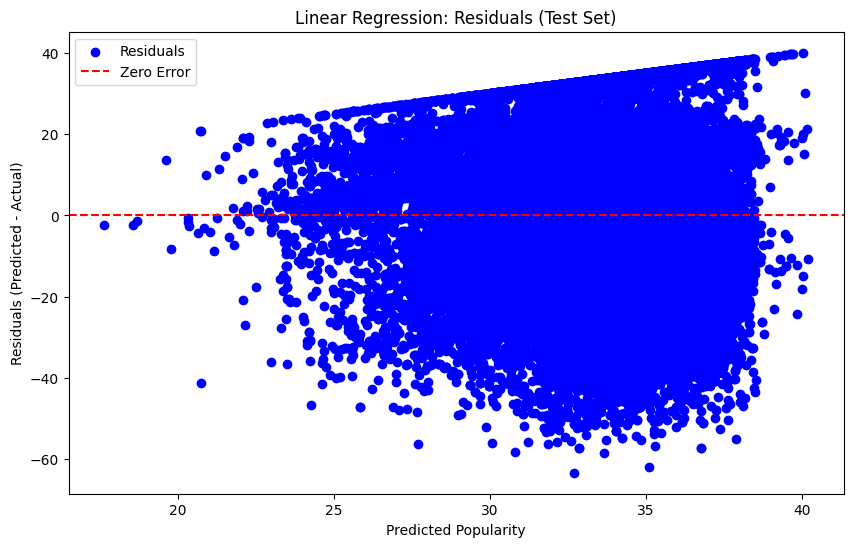

Displayed Residuals plot for the test set.


In [31]:
import matplotlib.pyplot as plt

# Predict values for the test set using the trained Linear Regression model
y_test_pred_lin = lin_reg.predict(X_test_scaled)

#  Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lin, color='blue', label="Predicted vs Actual")   # Scatter plot of actual vs predicted
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=2, label="Ideal Prediction")    # Ideal 1:1 line
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Linear Regression: Predicted vs Actual Popularity (Test Set)")
plt.legend()
plt.show()
print("Displayed Actual vs Predicted Popularity plot for the test set.")

# Plot Residuals (Predicted - Actual)
residuals = y_test_pred_lin - y_test  # Calculate residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lin, residuals, color='blue', label="Residuals")    # Scatter plot of residuals
plt.axhline(y=0, color='r', linestyle='--', label="Zero Error")   # Horizontal line at zero error
plt.xlabel("Predicted Popularity")
plt.ylabel("Residuals (Predicted - Actual)")
plt.title("Linear Regression: Residuals (Test Set)")
plt.legend()
plt.show()
print("Displayed Residuals plot for the test set.")


Ideally, in the Actual vs Predicted plot, the points should align closely with the red diagonal line, indicating that the model's predictions closely match the actual values. However, as observed, the points deviate significantly from the line, confirming poor prediction accuracy. This aligns with the previously calculated R^2 score, which was very low meaning the model explains only about 2% of the variance in the target variable (popularity). The scattered points far from the ideal line suggest the model is not capturing the underlying relationship between the predictors and the target variable effectively. The poor alignment suggests that a linear relationship may not adequately describe the relationship between the features and the target variable (popularity).

Ideally, in the residuals plot the residuals should be randomly distributed around the horizontal red dashed line (Zero Error). However, the residuals appear to fan out as the predicted popularity increases, suggesting heteroscedasticity (non-constant variance of errors). The residuals are spread across a large range, indicating significant prediction errors. Moreover, The vertical spread suggests that the model is not accurately capturing the underlying patterns in the data. This further indicates that linear model assumption is not valid for this dataset. There could be unmodeled relationships, such as non-linearity, that the linear regression model is failing to capture.

In [32]:
from sklearn.model_selection import cross_validate
import plotly.express as px

# Define a range of alpha values to test for Lasso regularization
alphas = np.logspace(-1, 4, 100)  # Logarithmic scale from 0.1 to 10,000


# Initialize a list to store cross-validation results
lasso_cv_scores = []

#Perform 10-fold cross-validation for each alpha value

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    # Perform cross-validation
    lasso_cv = cross_validate(
        estimator=lasso,
        X=X_train_scaled,  # Scaled training features
        y=y_train,  # Training target
        cv=10,  # 10-fold cross-validation
        scoring='neg_root_mean_squared_error'  # Use RMSE as the evaluation metric
    )

    lasso_cv_scores.append({
        'alpha': alpha,
        'log_alpha': np.log(alpha),  # Log of alpha for easier visualization
        'test_rmse': -np.mean(lasso_cv['test_score'])  # Convert negative RMSE to positive
    })

lasso_cv_scores_df = pd.DataFrame(lasso_cv_scores)

#Plot Test RMSE vs Log(alpha)
fig = px.line(
    lasso_cv_scores_df,
    x='log_alpha',
    y='test_rmse',
    title='Lasso Regression Cross-Validation: Test RMSE vs Alpha',
    labels={'log_alpha': 'Log (Alpha)', 'test_rmse': 'Test RMSE'}
)
fig.show()



# 3) Logistic Regression and ROC

We trained a logistic regression model using selected numeric features, from our previously completed forward feature selection (refer to the linear regression check-in code), to predict whether a track's popularity is above or below a set threshold. Model coefficients and intercepts are calculated to understand feature relationships.

In [33]:
# Compute logistic regression fit for entire training dataset.
from sklearn.linear_model import LogisticRegression

# Define the threshold for binary classification (create binary popularity var):
# 1 if popularity >= 50, 0 otherwise
spotify_cleaned.loc[:,'popularity_binary'] = (spotify_cleaned['popularity'] >= 50).astype(int)

# Specify numeric features used for logistic regression model
selected_features = ['danceability', 'speechiness', 'instrumentalness', 'valence']

# Train the logistic regression model
lr_all = LogisticRegression(solver='liblinear')
lr_all.fit(X=spotify_cleaned[selected_features],
           y=spotify_cleaned['popularity_binary'],)
# display model intercept and coefficients
lr_all.intercept_, lr_all.coef_

<ipython-input-33-f6c0d58ce7c1>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(array([-1.17469034]),
 array([[ 1.43530906, -1.717319  , -0.94030573, -1.13592591]]))

In [34]:
# Evaluate predictions using random sample of 20 validation set sessions.
# create a sample dataset for evaluation
sample_index = [961, 1315, 408, 1678, 1810,
                  1566, 2036, 1005, 2198, 685,
                  1680, 1347, 2265, 286, 1393,
                  2267, 2247, 1576, 217, 420]
sample_index = [id - 1 for id in sample_index]
spotify_sample = spotify_cleaned.loc[sample_index,:]

In [35]:
# Make predictions for the sample dataset
lr_predict_proba = lr_all.predict_proba(spotify_sample[selected_features])[:, 1]
lr_predict_binary = lr_all.predict(spotify_sample[selected_features])

# Create a DataFrame for the predictions to compare actual and predicted values
pred_val_sample = pd.DataFrame({
    'popularity': spotify_sample['popularity'].values,
    'lr_predict_proba': lr_predict_proba,
    'lr_predict_binary': lr_predict_binary
})

pred_val_sample

,popularity,lr_predict_proba,lr_predict_binary
0,46,0.304886,0
1,57,0.076480,0
2,54,0.339208,0
3,20,0.118967,0
4,41,0.124126,0
5,18,0.217351,0
6,0,0.263828,0
7,44,0.340591,0
8,0,0.293330,0
9,49,0.243816,0


### Validation and threshold optimization:
A random sample of tracks is used to evaluate the model's predictions.
5-fold cross-validation is used to assess precision, recall, and F1-score for various classification thresholds and the optimal threshold is determined by maximizing the F1-score.

Optimal Threshold: 0.21224181931468794


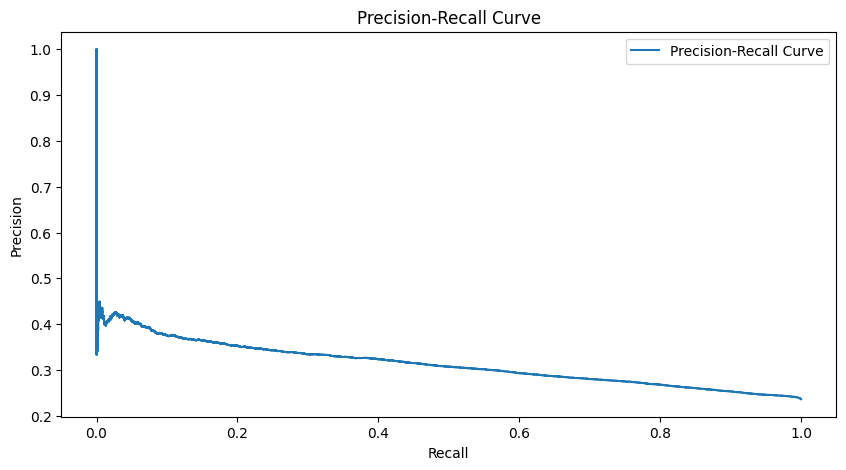

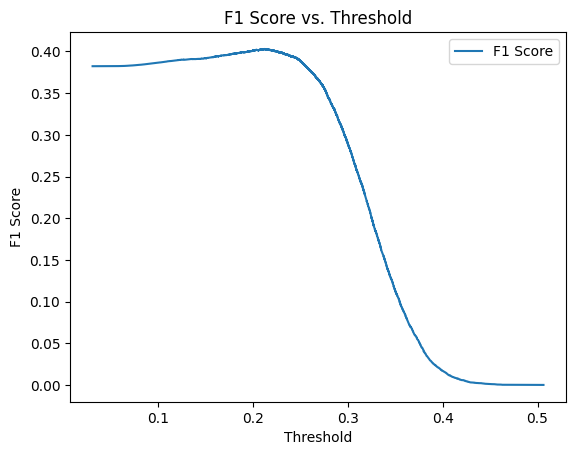

Final Accuracy with Optimal Threshold: 0.46994651214620015


In [36]:
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store all true labels and predicted probabilities
all_y_true = []  # True labels across all folds
all_y_pred_proba = []  # Predicted probabilities across all folds

# Stratified 5-fold cross-validation to maintain class balance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the target and features
y = spotify_cleaned['popularity_binary']
X = spotify_cleaned[selected_features]


# Iterate over each fold in the cross-validation
for train_index, test_index in skf.split(X, y):
    # Split data into training and validation sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the logistic regression model
    lr_model = LogisticRegression(solver='liblinear')
    lr_model.fit(X_train, y_train)

    # Predict probabilities for the positive class on the validation set
    y_pred_proba = lr_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (positive class)

    # Store true labels and predicted probabilities
    all_y_true.extend(y_test)
    all_y_pred_proba.extend(y_pred_proba)

# Convert lists to NumPy arrays
all_y_true = np.array(all_y_true)
all_y_pred_proba = np.array(all_y_pred_proba)

# Calculate precision, recall, and thresholds for all predictions
precisions, recalls, thresholds = precision_recall_curve(all_y_true, all_y_pred_proba)

# Compute F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Find the threshold that maximizes F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold: {optimal_threshold}")

# Plot Precision-Recall curve
plt.figure(figsize=(10, 5))

# Precision-Recall curve
plt.plot(recalls, precisions, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Plot F1 score vs. threshold
plt.figure()
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.show()

# Make final predictions using the optimal threshold
final_predictions = (all_y_pred_proba >= optimal_threshold).astype(int)

# Calculate final accuracy based on optimal threshold
final_accuracy = accuracy_score(all_y_true, final_predictions)
print(f"Final Accuracy with Optimal Threshold: {final_accuracy}")


###Confusion matrix and evaluation metrics
We created a confusion matrix to evaluate the logistic regression model performance with the optimized threshold. Accuracy, error rate, sensitivity, and specificity metrics are also computed and visualized.

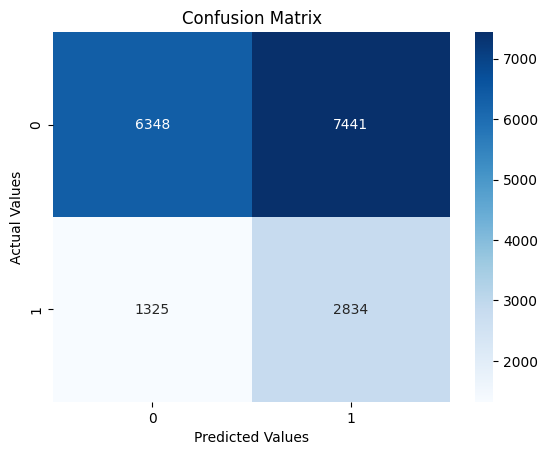

Confusion Matrix:
 [[6348 7441]
 [1325 2834]]
Accuracy: 0.511589034989971
Error Rate: 0.488410965010029
True Positive Rate (Sensitivity): 0.681413801394566
True Negative Rate (Specificity): 0.4603669591703532


In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Scale the features
X_scaled = StandardScaler().fit_transform(X)

# Split the data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train logistic regression
lr_train = LogisticRegression(solver='liblinear')
lr_train.fit(X_train_scaled, y_train)

# Predict probabilities on the test data
y_test_pred_proba = lr_train.predict_proba(X_test_scaled)

# Set a custom threshold for classification
threshold = 0.22680991433608036
y_test_pred_custom_threshold = (y_test_pred_proba[:, 1] >= threshold).astype(int)

# Calculate confusion matrix and metrics with the custom threshold
cm = confusion_matrix(y_test, y_test_pred_custom_threshold)
accuracy = accuracy_score(y_test, y_test_pred_custom_threshold)
error = 1 - accuracy
TPR = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # True Positive Rate (Sensitivity)
TNR = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True Negative Rate (Specificity)

# Plot confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

# Display results
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Error Rate:", error)
print("True Positive Rate (Sensitivity):", TPR)
print("True Negative Rate (Specificity):", TNR)


###ROC curve and AUC
Stratified 5-fold cross-validation calculates and plots ROC curves and AUC for each fold. We utilize 5-fold cross-validation to ensure the model is evaluated on different subsets of the data and to prevent possible overfitting. The mean ROC curve and AUC across all folds provide a comprehensive view of model performance, quantifying how well the model is able to distinguish between the classes of 'popular' or 'not popular' based on the selected features.

Fold 1 Accuracy: 0.7636505460218409
Fold 2 Accuracy: 0.7636505460218409
Fold 3 Accuracy: 0.7636505460218409
Fold 4 Accuracy: 0.7637062625362158
Fold 5 Accuracy: 0.7637062625362158


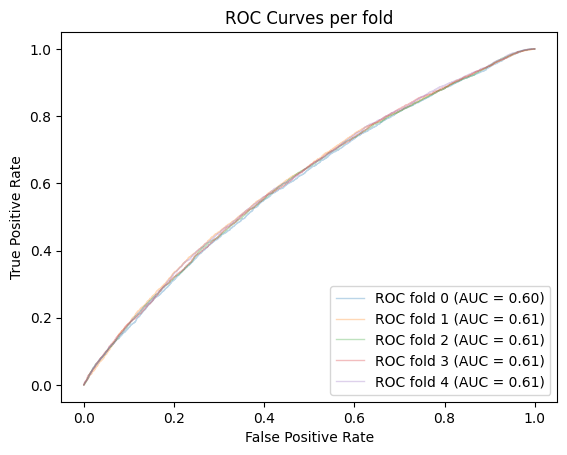

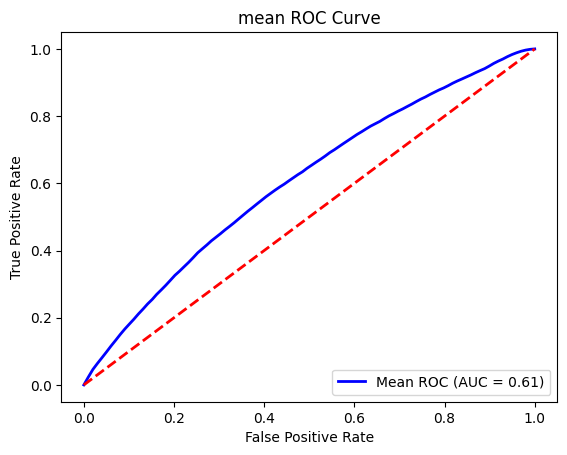

In [38]:
# Calculate and plot the ROC curve and AUC on your validation data set.
# Use 5-fold cross-validation on the validation set to calculate the AUC and accuracy of each fold.
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Create a StratifiedKFold object with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store true positive rates and area under curve values
# for each fold
tprs = []
aucs = []

# generate an evenly spaced array of false positive rates
# between 0 and 1 for interpolation
mean_fpr = np.linspace(0, 1, 100)

# Iterate over each fold in stratified K-fold split
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #train logistic regression model on training data
    lr_train = LogisticRegression(solver='liblinear')
    lr_train.fit(X_train, y_train)
    #predict probabilities for the positive class on test data
    y_test_pred_proba = lr_train.predict_proba(X_test)[:, 1]
    #calculate ROC curve (FPR, TPR) for test predictions
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    #interpolate TPR values to align them with the mean FPR array for averaging
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs
    tprs[-1][0] = 0.0
    #calculate AUC for this fold and store
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    aucs
    #plot ROC for this fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Calculate and print accuracy for this fold
    y_test_pred = lr_train.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Fold {i + 1} Accuracy: {accuracy}")

#plot ROC curves across all folds
plt.title('ROC Curves per fold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#calculate mean tpr across all folds
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
#calculate mean AUC across all folds
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f)' % mean_auc, lw=2, alpha=1)
plt.title('mean ROC Curve')
plt.legend(loc="lower right")
#plot diagonal dashed line to represent random classifer
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()



###Interpreting the results

Logistic regression was applied to classify Spotify tracks into 'popular' or 'not popular' categories based on the numeric features of danceability, speechiness, instrumentalness, and valence (as identified by forward feature selection). Our final analysis across all folds of the dataset shows that we have a around a 76% accuracy from each fold, indicating that the model's performance is stable across different splits of data and that the model generalizes well. Additionally, the low variance across folds, small number of features used, and the model's current ability to generalize suggest that there isn't a necessity for regularization so it was not performed. Feature importance was also indirectly assessed through coefficients, but explicit feature selection or ranking wasn't emphasized in this analysis.

A mean AUC of 0.61 also shows that the logistic regression model has a modest ability to distinguish between the classes of the binary popularity variable, indicating that it is only slightly better than random guessing as an AUC of 1.0 would demonstrate perfect discrimination of classes. In general, this result suggests that more relevant features could be tested, popularity prediction may be contingent on factors unrelated to the features, or that more complex algorithms (like random forest) should be explored as the logistic regression model may be underperforming due to more complex nonlinearity in the data.

# 4) Classification and Regression Tree (CART) and ROC

We are applying a CART (Classification and Regression Tree) as an alternative to the Random Forest Model in terms of types of decision tree models. A CART model is a single decision tree method for classification. It repeatedly splits data into two subsets based on feature thresholds to create a tree structure that simplifies the prediction process. CART uses impurity measures (like Gini impurity here for classification) to choose splits and grow the tree. Although highly interpretable, it can easily overfit, so constraints or pruning methods are often used to improve generalization. And like Random Forests, CART models can capture the non-linear relationships that are present in our attempt to predict popularity.

Here, we initialize an instance of our CART model and fit it to our traning data. We choose the following hyperparameters to prevent overfitting, as CART models are not ensemble methods inherently prevent it:
* min_samples_split=50
  * Reasoning: With 114,000 rows, very small splits (like the default of 2) allow the tree to grow complex and overfit quickly. Requiring at least 50 samples to split helps ensure each decision is based on a substantial amount of data.
* min_samples_leaf=10
  * Reasoning: Ensuring each leaf has a minimum of 10 samples reduces extreme splits and creates more stable, less overfitted leaf nodes.
* ccp_alpha=0.0001
  * Reasoning: Introducing pruning can simplify the tree and further prevents overfitting
It should also be said though that because the CART model is not an ensemble method, it is computationally cheaper than the Random Forest as it only needs to fit one decision tree.

The step-by-step procedure taken is the same as the one taken with the Random Forest Model in the main document. The only difference is that the model used is sklearn's DecisionTreeClassifier (a CART decision tree), and not the random forest model.

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Define features matrix and target matrix from cleaned dataset
X = spotify_clean.drop(columns=['track_id', 'artists', 'album_name','track_name', 'track_genre', 'popularity'])
y = spotify_clean['popularity']

# Turn target variable (popularity) into a binary variable to simplify model predictions
# Cut off of 35 used because that is the median of the popularty feature, reducing any potential unbalances in classification
y = (y >= 35).astype(int)

# Split data into training and testing sets, using an 80/20 split
X_train_popularity, X_test_popularity, y_train_popularity, y_test_popularity = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a CART model and fit the model on the training dataset
cart = DecisionTreeClassifier(
    criterion='gini',
    min_samples_split=50,
    min_samples_leaf=10,
    ccp_alpha=0.0001,
    random_state=42
)
cart.fit(X_train_popularity,
       y_train_popularity)

# compute validation set predictions (probability)
cart_val_pred = cart.predict_proba(X_test_popularity)

# extract just the positive class prediction from cart_val_pred for later ROC and further analysis
cart_val_pred = cart_val_pred[:, 1]

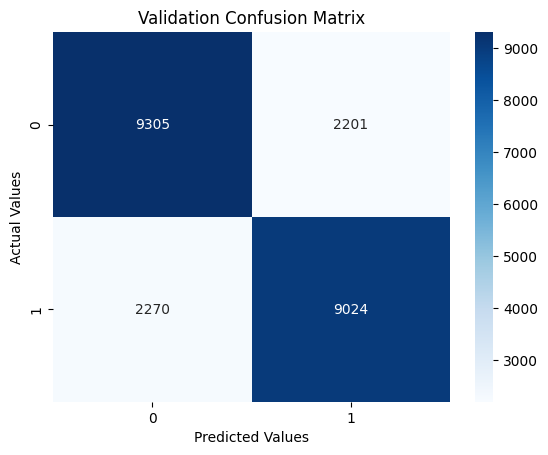

Validation Accuracy: 0.8039035087719298
Validation Error Rate: 0.19609649122807016
Validation True Positive Rate (Sensitivity): 0.7990083230033647
Validation True Negative Rate (Specificity): 0.8087084999130888
Validation F1 Score: 0.8014565478040766


In [59]:
# Calculate the Confusion Matrix, prediction accuracy, prediction error, true positive rate, and true negative rate, and F1 score on validation data set
# to analyze how well the model generalizes to new data
cm_val = confusion_matrix(y_test_popularity, cart.predict(X_test_popularity))
accuracy_val = accuracy_score(y_test_popularity, cart.predict(X_test_popularity))
error_val = 1 - accuracy_val
TPR_val = cm_val[1, 1] / (cm_val[1, 0] + cm_val[1, 1]) if (cm_val[1, 0] + cm_val[1, 1]) > 0 else 0
TNR_val = cm_val[0, 0] / (cm_val[0, 0] + cm_val[0, 1]) if (cm_val[0, 0] + cm_val[0, 1]) > 0 else 0
f1_val = f1_score(y_test_popularity, cart.predict(X_test_popularity))

# Heatmap for Validation Confusion Matrix
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

# Display results for validation set
print("Validation Accuracy:", accuracy_val)
print("Validation Error Rate:", error_val)
print("Validation True Positive Rate (Sensitivity):", TPR_val)
print("Validation True Negative Rate (Specificity):", TNR_val)
print("Validation F1 Score:", f1_val)

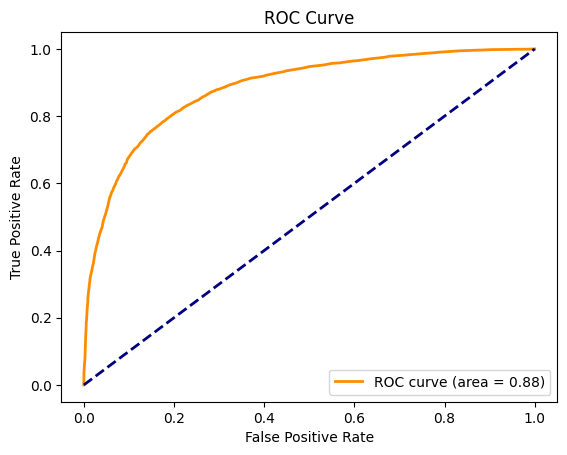

In [60]:
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score

# Calculate and plot the ROC curve and AUC on your validation data set
fpr, tpr, thresholds = roc_curve(y_test_popularity, cart_val_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

** Evaluation Metrics**

So, we see the following metrics from our CART model on the validation data:
* Validation Accuracy: 0.8039035087719298
* Validation Error Rate: 0.19609649122807016
* Validation True Positive Rate (Sensitivity): 0.7990083230033647
* Validation True Negative Rate (Specificity): 0.8087084999130888
* Validation F1 Score: 0.8014565478040766
* AUROC: 0.88

While giving decent performance, these metrics ultimately do not compare to the Random Forest Model described in the main document. This highlights the limitations of the CART model, as a single CART tree tends to overfit and vary greatly with the training data. In contrast, a Random Forest model averages the results of many CART trees built from different bootstrapped data and feature subsets, reducing variance and improving predictive accuracy. So, the ensemble approach makes Random Forests generally more robust and effective than a single CART model, ultimately leading us to use Random Forests for our main method and leave the CART model here in the appendix as a computationally cheaper alternative.

# 5) Unsupervised learning: PCA and Clustering
We are applying PCA on our dataset to reduce dimensionality and find the strongest relationships between variables in the data. This also makes computation easier.

Here we use the numeric features since PCA requires numeric features and the categorical variables (track id, track name, artist, etc. are not that relevant to popularity). Then out of all of our variables, we can understand feature relationships and visualize our data.

Here are the steps we go through below:

1. Perform PCA on numeric features only
2. Interpreting the principal components:
analyze the loadings of each principal component to understand which predictor variables are most strongly associated with the components
3. Regression analysis: use separate regression analysis to examine the relationship between the extracted principal components and "popularity" to identify the most significant predictors

In [42]:
# Prepare dataset for PCA by using all numeric features
X_numeric = spotify_cleaned[numeric_features]
y = spotify_cleaned['popularity']  # Response variable

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Split data into training and testing sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

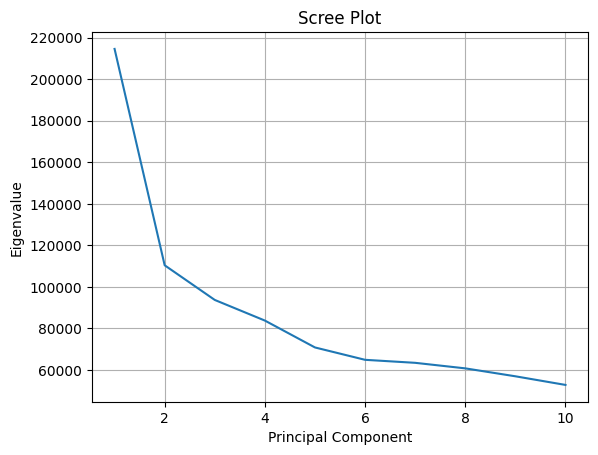

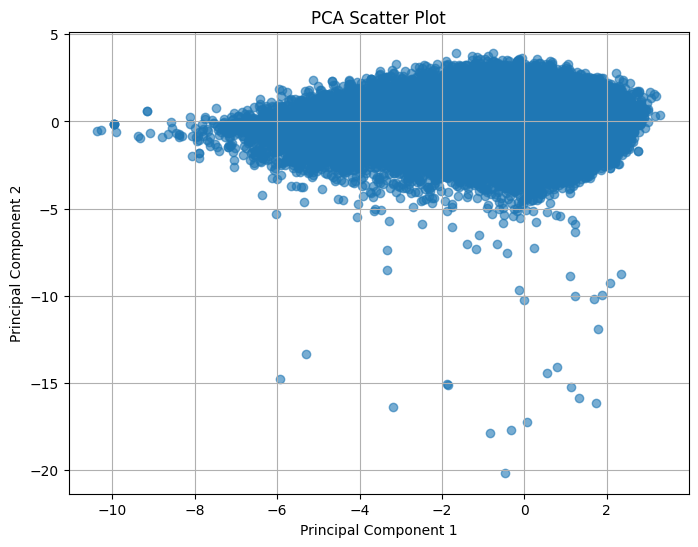

Singular Values: [463.24800668 332.30206724]
PCA Components Shape: (2, 13)


In [43]:
# Step 1: PCA analysis: Use standardized numeric features and perform PCA only on the training data set
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Perform PCA on training set
pca = PCA(n_components=None)  # Keep all components initially
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform test set using the same PCA model
X_test_pca = pca.transform(X_test_scaled)

# Scree Plot
X_train_scaled = X_train_scaled - np.mean(X_train_scaled, axis=0)
cov_mat = np.matmul(np.transpose(X_train_scaled),X_train_scaled)
cov_mat.shape

eigenvals, eigenvecs = np.linalg.eig(cov_mat)

# # Plot Scree Plot
ids = eigenvals.argsort()[::-1]
sorted_eigenvals = eigenvals[ids]
sorted_eigenvecs = eigenvecs[:,ids]
plt.plot(range(1,11),sorted_eigenvals[0:10])
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# PCA with 2 components for visualization
pca_2d = PCA(n_components=2, svd_solver='full')
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)

# Scatter Plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], alpha=0.6)
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Summary Outputs
print(f"Singular Values: {pca_2d.singular_values_}")
print(f"PCA Components Shape: {pca_2d.components_.shape}")

In [44]:
# Step 2: Analyze the loadings of each principal component
# Loadings are the coefficients of the original features in the principal components

# Loadings for PCA
loadings = pd.DataFrame(pca_2d.components_.T, columns=['PC1', 'PC2'], index=numeric_features)

# Show the top features contributing to each principal component
top_features_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(10)
top_features_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(10)

print("Top Features Contributing to PC1:")
print(top_features_pc1)

print("Top Features Contributing to PC2:")
print(top_features_pc2)

Top Features Contributing to PC1:
loudness            0.502786
energy              0.491903
acousticness        0.424500
valence             0.293781
instrumentalness    0.272346
danceability        0.261142
time_signature      0.198404
tempo               0.196255
speechiness         0.088959
liveness            0.075030
Name: PC1, dtype: float64
Top Features Contributing to PC2:
valence             0.481917
danceability        0.453936
duration_ms         0.418015
acousticness        0.330533
instrumentalness    0.328892
energy              0.268637
tempo               0.211707
liveness            0.128214
mode                0.127965
speechiness         0.088907
Name: PC2, dtype: float64


In [45]:
# Step 3: Regression Analysis
regressor = LinearRegression()
regressor.fit(X_train_pca_2d, y_train)

# Coefficients of regression
coefficients = pd.DataFrame({
    'Principal Component': ['PC1', 'PC2'],
    'Coefficient': regressor.coef_
})

# Displaying the coefficients
print("Regression Analysis Coefficients:")
print(coefficients)

Regression Analysis Coefficients:
  Principal Component  Coefficient
0                 PC1     0.766702
1                 PC2     0.627109


**Interpreting the Results:**


*  From the Regression Analysis:

PC1 has a higher coefficient (0.76) compared to PC2 (0.62), indicating that PC1 is a stronger predictor of popularity. This suggests that the original features contributing most to PC1 are the most influential in predicting popularity.
*   Top Features of PC1:

The features with the largest loadings for PC1 are **loudness, energy, and acousticness.**
These loadings indicate how much each feature contributes to PC1. Since their coefficients are positive, increases in these features are associated with increases in popularity.
- PC2’s Contribution:

Although PC2 has a smaller regression coefficient, it still provides some predictive power.
The top contributors to PC2 are **valence, danceability, and duration_ms**. Positive loadings for these features suggest that increases in these attributes are weakly associated with increases in popularity.



# **Clustering PCA-Transformed Data**

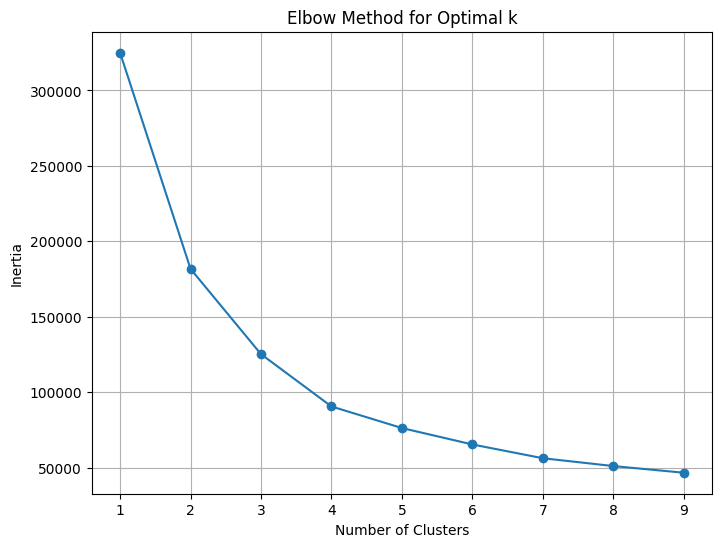

In [46]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Elbow Method
inertia = []
range_n_clusters = range(1, 10)  # Test for 1 to 10 clusters
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca_2d)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


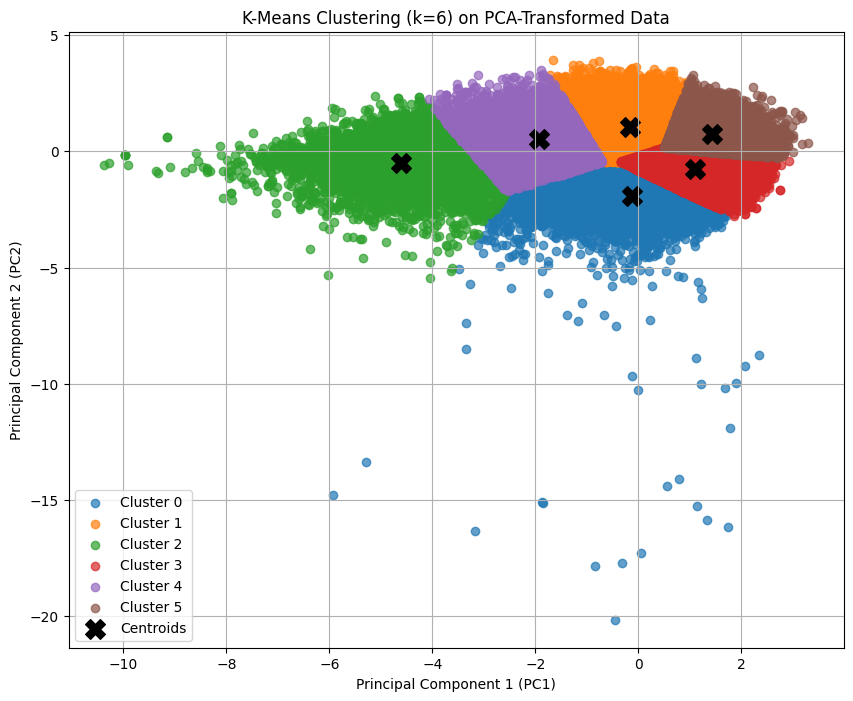

In [47]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Perform K-Means clustering with k = 6
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_pca_2d)

# Add cluster labels to the PCA data for plotting
spotify_clustered = pd.DataFrame(X_train_pca_2d, columns=['PC1', 'PC2'])
spotify_clustered['Cluster'] = cluster_labels

# Plot the clusters on a scatter plot
plt.figure(figsize=(10, 8))
for cluster in range(6):  # Loop through each cluster
    cluster_data = spotify_clustered[spotify_clustered['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)

# Add cluster centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, marker='X', label='Centroids')

# Plot formatting
plt.title('K-Means Clustering (k=6) on PCA-Transformed Data')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
# Add cluster labels back to the dataset
spotify_clustered = pd.DataFrame(X_train_pca_2d, columns=['PC1', 'PC2'])
spotify_clustered['Cluster'] = cluster_labels
spotify_clustered['Popularity'] = y_train.reset_index(drop=True)

# Analyze the average popularity within each cluster
cluster_analysis = spotify_clustered.groupby('Cluster')['Popularity'].mean()
print("Average Popularity by Cluster:")
print(cluster_analysis)

Average Popularity by Cluster:
Cluster
0    30.580438
1    35.039880
2    28.179869
3    34.757867
4    31.392287
5    34.018482
Name: Popularity, dtype: float64


**Interpreting Clusters:**

According to the average popularity per cluster, the clusters don't appear to be meaningfully associated with popularity (they all have similar popularity).

**Final Interpretation of PCA and Clustering:**
PCA and clustering were not good methods for predicting popularity, but PCA could be used as a feature selection method since some features were shown to be more strongly associated with popularity.

Since our problem was a prediction problem and not a classification problem, clustering did not end up being a good method to draw any insights as to which groups of features (PCs) were more associated with popularity.

# 6) Neural Networks

We attempted to use a neural network to build non-linear model to predict popularity of in the spotify dataset. We converted popularity to a binary variable with a threshold of 0.5 for this prediction, with 0 being not popular and 1 being popular.

First, we began by preprocessing our data by selecting our features (we use all the numeric features in our dataset) and our target variable, popularity, converting it to binary, and creating our training, validation, and test sets.

In [49]:
# Preprocessing for neural network
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_curve, auc

# Load spotify_cleaned data (example dataset structure assumed)
target = 'popularity'

X = spotify_cleaned[numeric_features].values
y = spotify_cleaned[target].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# convert popularity into binary variable with threshold of 0.5.
# 0 being not popular and 1 being popular
y = (y >= 50).astype(int)

# Split into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

Then we convert our data to tensors so we can use the PyTorch library for our Neural Network.

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use long for classification

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)



In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Helper function for one-hot encoding
def int_to_onehot(y, num_labels):
    onehot = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        onehot[i, val] = 1
    return onehot

# Compute MSE and accuracy
def compute_mse_and_acc(model, X, y, num_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X, dtype=torch.float32))
        probas = torch.softmax(outputs, dim=1).numpy()  # Softmax for probabilities
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(y, num_labels=num_labels)
        mse = np.mean((onehot_targets - probas)**2)
        acc = np.mean(predicted_labels == y)
    return mse, acc

In [52]:
# Training function
def train(model, optimizer, criterion, scheduler, X_train, y_train, X_valid, y_valid, num_epochs, batch_size):
    num_labels = len(np.unique(y_train))
    epoch_loss, epoch_train_acc, epoch_valid_acc = [], [], []

    # Create DataLoader for batching
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                   torch.tensor(y_train, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()  # Set to training mode
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Clear gradients
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Log training loss and accuracy
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train, num_labels)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid, num_labels)
        epoch_loss.append(running_loss / len(train_loader))
        epoch_train_acc.append(train_acc * 100)
        epoch_valid_acc.append(valid_acc * 100)

        # Step the scheduler
        scheduler.step()

        print(f'Epoch {epoch+1:03d}/{num_epochs:03d} | '
              f'Train MSE: {train_mse:.2f} | Train Acc: {train_acc*100:.2f}% | '
              f'Valid Acc: {valid_acc*100:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [53]:
# Plot metrics
def plot_metrics(epoch_loss, epoch_train_acc, epoch_valid_acc):
    # Plot MSE vs. Epoch
    plt.figure()
    plt.plot(range(len(epoch_loss)), epoch_loss, label='Training MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.title('Training MSE vs. Epoch')
    plt.legend()
    plt.show()

    # Plot Accuracy vs. Epoch
    plt.figure()
    plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training Accuracy')
    plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Epoch')
    plt.legend()
    plt.show()


**Network Architecture**
*   Our model has 1 hidden layer with 128 units and uses ReLU activation.
*   We use the Adam optimizer to optimize our learning rate.
- We use cross entropy loss for our loss function since it goes well with Classification.
- We also included a learning rate schedule to reduce the learning rate to prevent overshooting.

**Hyperparameters**
*   Chosen through experimentation
*   A smaller learning rate help us smooth out fluctuations in MSE.




Epoch 001/025 | Train MSE: 0.17 | Train Acc: 76.28% | Valid Acc: 76.32%
Epoch 002/025 | Train MSE: 0.17 | Train Acc: 76.49% | Valid Acc: 76.58%
Epoch 003/025 | Train MSE: 0.17 | Train Acc: 76.52% | Valid Acc: 76.52%
Epoch 004/025 | Train MSE: 0.17 | Train Acc: 76.48% | Valid Acc: 76.58%
Epoch 005/025 | Train MSE: 0.17 | Train Acc: 76.50% | Valid Acc: 76.54%
Epoch 006/025 | Train MSE: 0.17 | Train Acc: 76.39% | Valid Acc: 76.54%
Epoch 007/025 | Train MSE: 0.17 | Train Acc: 76.42% | Valid Acc: 76.56%
Epoch 008/025 | Train MSE: 0.17 | Train Acc: 76.50% | Valid Acc: 76.78%
Epoch 009/025 | Train MSE: 0.17 | Train Acc: 76.39% | Valid Acc: 76.38%
Epoch 010/025 | Train MSE: 0.17 | Train Acc: 76.39% | Valid Acc: 76.50%
Epoch 011/025 | Train MSE: 0.17 | Train Acc: 76.52% | Valid Acc: 76.62%
Epoch 012/025 | Train MSE: 0.17 | Train Acc: 76.48% | Valid Acc: 76.76%
Epoch 013/025 | Train MSE: 0.16 | Train Acc: 76.49% | Valid Acc: 76.42%
Epoch 014/025 | Train MSE: 0.16 | Train Acc: 76.58% | Valid Acc:

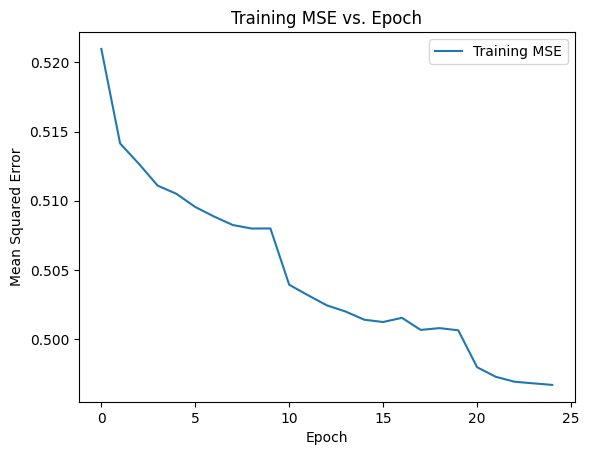

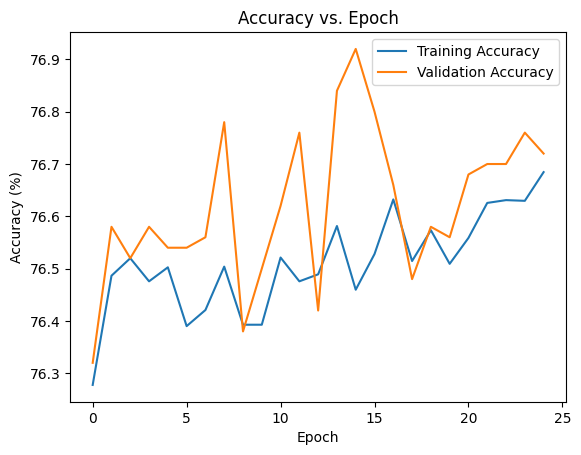

Test MSE: 0.17 | Test Accuracy: 76.39%


In [54]:
# Define model, loss, optimizer, and hyperparameters
class NeuralNetMLP(nn.Module):
    def __init__(self, num_features, num_hidden, num_classes):
        super(NeuralNetMLP, self).__init__()
        self.hidden = nn.Linear(num_features, num_hidden)
        self.output = nn.Linear(num_hidden, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.output(x)
        return x

# Initialize variables
num_features = X_train.shape[1]
num_hidden = 128
num_classes = len(np.unique(y_train))
model = NeuralNetMLP(num_features, num_hidden, num_classes)

criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=0.005) # Adam optimizer to minimize the loss function during the training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Reduce LR every 10 epochs by 50%

num_epochs = 25
batch_size = 32

# Train the model
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, optimizer, criterion, scheduler, X_train, y_train, X_valid, y_valid, num_epochs, batch_size
)

# Plot metrics
plot_metrics(epoch_loss, epoch_train_acc, epoch_valid_acc)

# Evaluate on test set
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test, num_classes)
print(f'Test MSE: {test_mse:.2f} | Test Accuracy: {test_acc*100:.2f}%')


**Evaluation Metrics**

We are using MSE and accuracy as our evaluation metrics. The test set was used only after the training process to evaluate the final performance.

- Training and Validation Metrics
  - The training MSE remains consistently around 0.17–0.18 throughout training, suggesting that the model has stabilized and is learning the relationship between the predictors and the target variable.
- Training Accuracy and Validation Accuracy are very close throughout training, indicating no significant overfitting.
  - Final Training Accuracy: ~76.68%.
  - Final Validation Accuracy: ~76.72%.

- Test Performance
  - The Test MSE is similar to the training and validation MSE (~0.17), and the Test Accuracy is 76.39%.
  - This suggests that the model generalizes well, as there is no significant drop in performance when tested on unseen data.
- Plateau in Learning
  - Training and validation metrics plateau after around 25 epochs, suggesting that the model reaches its performance limits and further training does not significantly improve results.
  - The small fluctuations in validation accuracy are likely due to random variations in the validation set.




**Conclusions from Neural Network**

- The model performs consistently across training, validation, and test sets, indicating it has learned the underlying patterns without overfitting.
However, an accuracy of ~76% suggests that the model struggles to achieve higher predictive power. This could mean that the features may not be fully representative of the factors influencing popularity, or the model architecture or hyperparameters might need improvement.